# Linear Regression

1. Plot the data for a quick visual inspection.
2. Calculate an estimated line of best fit using Least Squares.
3. Calculate the $R^2$ score, and it's statistical significance.
4. Repeat steps 2 & 3 using sklearn.
5. Compare homebrewed vs sklearn results.

So, what does the scatter plot look like? Looks correlated to me, what a surprise!

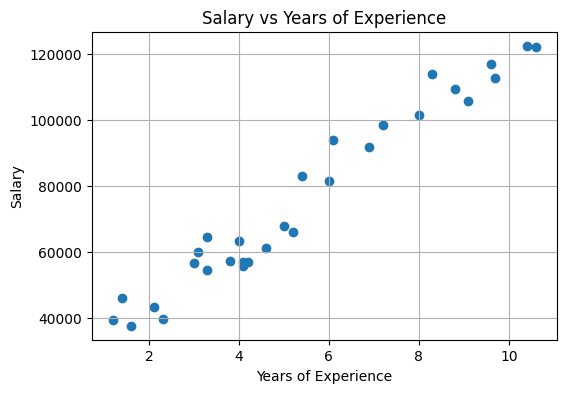

,Unnamed: 0,YearsExperience,Salary
0,0,1.2,39344.0
1,1,1.4,46206.0
2,2,1.6,37732.0
3,3,2.1,43526.0
4,4,2.3,39892.0


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("salary.csv")
plt.figure(figsize=(6, 4))
plt.scatter(data["YearsExperience"], data["Salary"])
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.title("Salary vs Years of Experience")
plt.grid(True)

plt.show()
data.head()

## Step 2. Estimate a line of best fit using Least Squares

I want to have a crack at writing my own, without looking at sample code.

- Get the mean years of xp. I'll start with a straight line on that.

In [30]:
# Calculates SSE / loss function
def lossFunction(yTrue, yPredicted):
    return np.sum((yTrue - yPredicted) ** 2)

# Class to represent a linear function
# y = mx + b
# target = weight * feature + bias
class LinearFunction:
    def __init__(self, weight, bias):
        self.weight = weight
        self.bias = bias

    def __call__(self, x):
        return self.weight * x + self.bias

# generate 10 random weights inclusive of upper and lower
def tenRandomWeights(upper, lower):
    return np.random.uniform(lower, upper, size=10)

# generate 10 random biases inclusive of upper and lower
def tenRandomBiases(upper, lower):
    return np.random.uniform(lower, upper, size=10)

# Recursive function to find the best fit line
# Take an upper and lower function, try 100 in between,
# Pick the best one, and pass it's neighbors to the next iteration
def findBestFitLine(xValues, yValues, upperFunc, lowerFunc, currentI, totalI, shrinkage):
    randomWeights = tenRandomWeights(upperFunc.weight, lowerFunc.weight)
    randomBiases = tenRandomBiases(upperFunc.bias, lowerFunc.bias)

    # Generate 100 functions within current box, find best
    funcs = pd.DataFrame(columns=["loss", "func"])
    for weight in randomWeights:
        for bias in randomBiases:
            func = LinearFunction(weight, bias)
            yPredicted = func(xValues)
            loss = lossFunction(yValues, yPredicted)
            funcs.loc[len(funcs)] = {
                "loss": loss,
                "func": func,
            }
    bestFuncRow = funcs.loc[funcs["loss"].idxmin()]
    bestFunc = bestFuncRow["func"]
    
    # Shrink the box, this took several attempts to figure out, about an hour
    weightRange = upperFunc.weight - lowerFunc.weight
    biasRange = upperFunc.bias  - lowerFunc.bias
    weightHalf = (weightRange * shrinkage) / 2.0
    biasHalf = (biasRange * shrinkage) / 2.0
    newWeightMin = bestFunc.weight - weightHalf
    newWeightMax = bestFunc.weight + weightHalf
    newBiasMin   = bestFunc.bias  - biasHalf
    newBiasMax   = bestFunc.bias  + biasHalf
    upperFunc = LinearFunction(newWeightMax, newBiasMax)
    lowerFunc = LinearFunction(newWeightMin, newBiasMin)

    # Return when iterations exhausted 
    if currentI == totalI:
        return bestFuncRow

    # Recurse with smaller box
    return findBestFitLine(xValues, yValues, upperFunc, lowerFunc, currentI + 1, totalI, shrinkage)

In [25]:
# Make an initial guess of the upper and lower based on visual inspection.
# For my initial guess, I'll start with bias of min salary, because visually it looks like a good guess
# For my initial guess of weight I'll start with a straight line, 0.
# y = 0*x + minSalary
minSalary = data['Salary'].min()
# Visually I can tell it's positive, so I'll start with a very small weight
# Bias looks above 0 too, to start at 0
lowerFunction = LinearFunction(0.000001, 0)
# The weight isn't this strong, so good place to start
#   Here I initially assumed that the weight only goes up from -1 to 1, that produced
#   terrible results and I had to ask chatgpt for help!
# The bias was judge visually again
upperFunction = LinearFunction(100000, minSalary + 100000)

xValues = data['YearsExperience'].values
yValues = data['Salary'].values
bestFitFunc = findBestFitLine(xValues, yValues, upperFunction, lowerFunction, currentI=0, totalI=50, shrinkage=0.5)

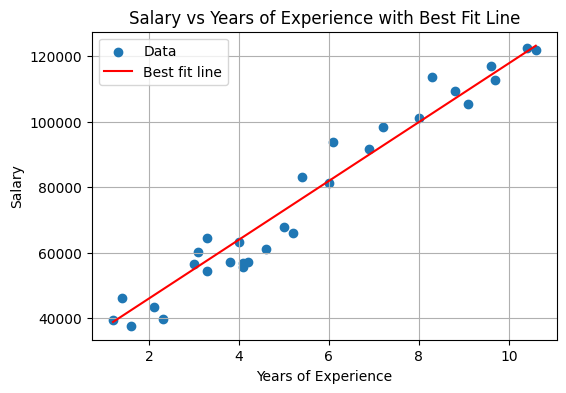

In [26]:
x = data["YearsExperience"].values
y = data["Salary"].values

bestFitFunc = bestFitFunc["func"]
weight = bestFitFunc.weight
bias = bestFitFunc.bias

xLine = np.linspace(x.min(), x.max(), 100)
yLine = bestFitFunc(xLine)

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label="Data")
plt.plot(xLine, yLine, color="red", label="Best fit line")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.title("Salary vs Years of Experience with Best Fit Line")
plt.grid(True)
plt.legend()
plt.show()

## R squared and F statistic

Lets check how well the model fits the data using R squared and F statistic.

In [27]:
from sklearn.metrics import r2_score
from scipy.stats import f

yPred = bestFitFunc(x)

r2 = r2_score(y, yPred)

# I couldn't find a library that'd take my func and calculate the F statistic.
# So chatGPT time. Coding it myself didn't seem that useful for learning
def fStatistic(bestFitFunc):
    x = data["YearsExperience"].values
    y = data["Salary"].values
    y_pred = bestFitFunc(x)

    y_mean = np.mean(y)

    ss_res = np.sum((y - y_pred) ** 2)        # SSE
    ss_reg = np.sum((y_pred - y_mean) ** 2)   # SSR

    n = len(y)
    p = 1

    ms_reg = ss_reg / p
    ms_res = ss_res / (n - p - 1)
    F = ms_reg / ms_res

    p_value = f.sf(F, p, n - p - 1)

    return p_value, F

p_value, F = fStatistic(bestFitFunc)

print("R^2:", r2)
print("F statistic:", F)
print("F p-value: {:.18f}%".format(p_value * 100))

R^2: 0.9538771686020373
F statistic: 524.2269862950302
F p-value: 0.000000000000000011%


lol, pretty good. 95% of the variance in the data is explained by the model. Very, very small chance of this occurring due to random chance.

So how does this compare to a scikit-learn linear regression?

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

x = data[["YearsExperience"]].values
y = data["Salary"].values

model = LinearRegression()
model.fit(x, y)

yPrediction = model.predict(x)

r2 = r2_score(y, yPrediction)

fValues, pValues = f_regression(x, y)
fStatistic = fValues[0]
pValue = pValues[0]

print(f"R^2: {r2}")
print(f"F statistic: {fStatistic}")
print("F p-value: {:.18f}%".format(pValue * 100))

R^2: 0.9569566641435086
F statistic: 622.5072026330107
F p-value: 0.000000000000000001%


## Comparing the results

| Model | R²                  | F statistic         | F p-value                 |
|-------|---------------------|---------------------|---------------------------|
| homemade | 0.9569566275277481  | 622.2902253407284   | 0.000000000000000001%     |
| scikit   | 0.9569566641435086  | 622.5072026330107   | 0.000000000000000001%     |

Pretty similar!

Nice. For a really simple pretend data set, I can do machine learning. Got to start somewhere...

This data is very correlated, my model would be a good predictor of future results.

Given how simple the data is the chance of overfitting is very low. However, at this stage I've no idea how I'd test for it anyway!